# Optimizing Model Prediction

This project will use a forest fire dataset from the UIC Machine Learning Repository to predict the extent of fire damage to a forest. We will use various machine learning techniques to optimize the model

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

# importing libraries

In [2]:
fires = pd.read_csv("fires.csv")
fires.head()

# importing and reviewing data

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,1,7,5,mar,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0
1,2,7,4,oct,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0
2,3,7,4,oct,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0
3,4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0
4,5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0


In [3]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  517 non-null    int64  
 1   X           517 non-null    int64  
 2   Y           517 non-null    int64  
 3   month       517 non-null    object 
 4   day         517 non-null    object 
 5   FFMC        469 non-null    float64
 6   DMC         496 non-null    float64
 7   DC          474 non-null    float64
 8   ISI         515 non-null    float64
 9   temp        496 non-null    float64
 10  RH          487 non-null    float64
 11  wind        482 non-null    float64
 12  rain        485 non-null    float64
 13  area        517 non-null    float64
dtypes: float64(9), int64(3), object(2)
memory usage: 56.7+ KB


In [4]:
model = LinearRegression()

# instantiating a linear model

### Data Cleaning

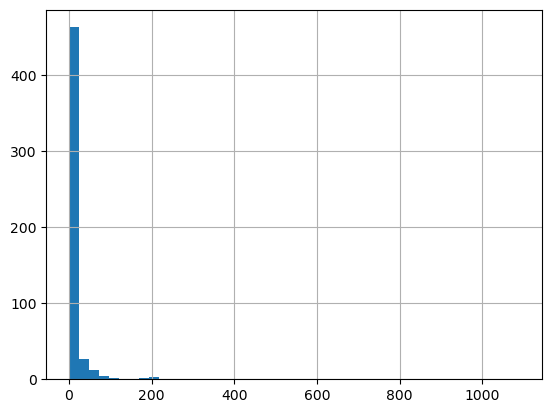

In [5]:
hist = fires["area"].hist(bins = 45)

# reviewing the distribution of our target variable

We can see the distribution is highly skewed right.  We can use a logarithmic transformation to try and normalize these values

array([[<AxesSubplot:title={'center':'log_area'}>]], dtype=object)

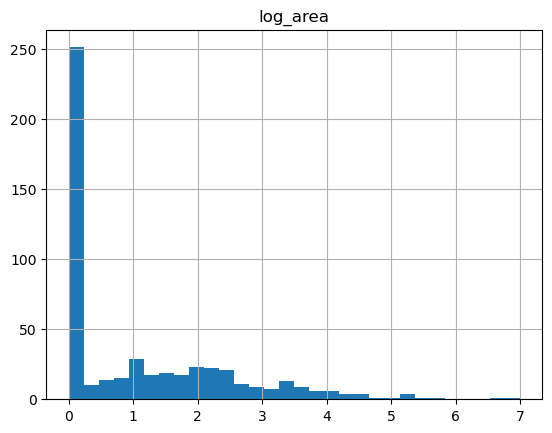

In [6]:
fires["log_area"] = np.log(fires["area"] + 1)

fires.hist("log_area", bins=30)

# log function for area.  Adds 1 to prevent undefined errors at log(0)

We can see this worked fairly well even though we still have a large cluster close to 0.

In [7]:
fires.groupby("month")["area"].mean()

# reviewing mean by month to confirm if any season grouping is worth capturing.  Not any evident pattern to where it's worth doing

month
apr     8.891111
aug    12.489076
dec    13.330000
feb     6.275000
jan     0.000000
jul    14.369687
jun     5.841176
mar     4.356667
may    19.240000
nov     0.000000
oct     6.638000
sep    17.942616
Name: area, dtype: float64

### Updating categorical data

In [8]:
replacement = {"jan" : 1, "feb" : 2, "mar" : 3, "apr" : 4, "may" : 5, "jun" : 6, "jul" : 7,
               "aug" : 8, "sep" : 9, "oct" : 10, "nov" : 11, "dec": 12}

# creating numerical mapping for months

In [9]:
fires["month"].replace(replacement, inplace = True)
fires.head()

# overwriting the month values and confirming they're correct

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,log_area
0,1,7,5,3,fri,86.2,26.2,94.3,5.1,NaN,51.0,6.7,0.0,0.0,0.0
1,2,7,4,10,tue,90.6,NaN,669.1,6.7,18.0,33.0,0.9,0.0,0.0,0.0
2,3,7,4,10,sat,90.6,43.7,NaN,6.7,14.6,33.0,1.3,0.0,0.0,0.0
3,4,8,6,3,fri,91.7,33.3,77.5,9.0,8.3,97.0,4.0,0.2,0.0,0.0
4,5,8,6,3,sun,89.3,51.3,102.2,9.6,11.4,99.0,NaN,0.0,0.0,0.0


In [10]:
fires = pd.concat([fires, pd.get_dummies(fires["day"])], axis = 1)
fires.head()

# creating numerical columns for the day of the week column and confirming it worked correctly

,Unnamed: 0,X,Y,month,day,FFMC,DMC,DC,ISI,temp,...,rain,area,log_area,fri,mon,sat,sun,thu,tue,wed
0,1,7,5,3,fri,86.2,26.2,94.3,5.1,NaN,...,0.0,0.0,0.0,1,0,0,0,0,0,0
1,2,7,4,10,tue,90.6,NaN,669.1,6.7,18.0,...,0.0,0.0,0.0,0,0,0,0,0,1,0
2,3,7,4,10,sat,90.6,43.7,NaN,6.7,14.6,...,0.0,0.0,0.0,0,0,1,0,0,0,0
3,4,8,6,3,fri,91.7,33.3,77.5,9.0,8.3,...,0.2,0.0,0.0,1,0,0,0,0,0,0
4,5,8,6,3,sun,89.3,51.3,102.2,9.6,11.4,...,0.0,0.0,0.0,0,0,0,1,0,0,0


### Imputing missing values

In [11]:
from sklearn.impute import KNNImputer

imp = KNNImputer(missing_values = np.nan, n_neighbors=3)

fires_missing = fires[fires.columns[5:13]] # FFMC to rain
imputed = pd.DataFrame(imp.fit_transform(fires_missing), 
                       columns = fires.columns[5:13])
imputed

# imputing missing values on numerical columns using KNN nearest neighbor

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,86.2,26.200000,94.300000,5.1,16.6,51.0,6.700000,0.0
1,90.6,56.433333,669.100000,6.7,18.0,33.0,0.900000,0.0
2,90.6,43.700000,470.833333,6.7,14.6,33.0,1.300000,0.0
3,91.7,33.300000,77.500000,9.0,8.3,97.0,4.000000,0.2
4,89.3,51.300000,102.200000,9.6,11.4,99.0,4.333333,0.0
...,...,...,...,...,...,...,...,...
512,81.6,56.700000,665.600000,1.9,27.8,32.0,2.700000,0.0
513,81.6,56.700000,665.600000,1.9,21.9,71.0,5.800000,0.0
514,81.6,56.700000,665.600000,1.9,21.2,70.0,6.700000,0.0
515,94.4,146.000000,614.700000,11.3,25.6,42.0,4.000000,0.0


### Exploring outliers

<AxesSubplot:>

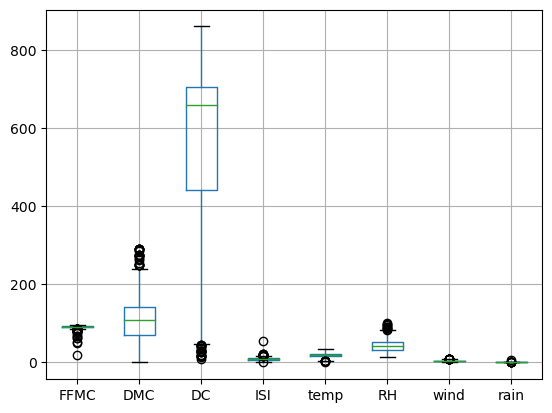

In [12]:
imputed.boxplot(column=["FFMC", "DMC", "DC", "ISI", "temp", "RH", "wind", "rain"])

# reviewing the distribution including imputed values to verify outliers

In [13]:
ffmc_quart = np.percentile(imputed["FFMC"], [25, 50, 75])
iqr = ffmc_quart[2] - ffmc_quart[0]
lower_bound = ffmc_quart[0] - (1.5 * iqr)
upper_bound = ffmc_quart[2] + (1.5 * iqr)

# calculting the quartiles and upper and lower bounds

In [14]:
for col in imputed:

    quartiles = np.percentile(imputed[col], [25, 50, 75])
    iqr = quartiles[2] - quartiles[0]
    lower_bound = quartiles[0] - (1.5 * iqr)
    upper_bound = quartiles[2] + (1.5 * iqr)
    num_outliers =sum((imputed[col] < lower_bound) | (imputed[col] > upper_bound))

    print(f"The {col} column has {num_outliers} according to the boxplot method.")
    
# loop to count the number     

The FFMC column has 53 according to the boxplot method.
The DMC column has 22 according to the boxplot method.
The DC column has 25 according to the boxplot method.
The ISI column has 23 according to the boxplot method.
The temp column has 9 according to the boxplot method.
The RH column has 10 according to the boxplot method.
The wind column has 13 according to the boxplot method.
The rain column has 8 according to the boxplot method.


Outliers may need to be further researched however none stand out significantly enough on the boxplot to raise any obvious flags.  Will include all values in the model.

### Applying a scalar to numerical values

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled = scaler.fit_transform(imputed)
scaled = pd.DataFrame(scaled, columns = imputed.columns)

scaled

,FFMC,DMC,DC,ISI,temp,RH,wind,rain
0,-0.812283,-1.335942,-1.846711,-0.860187,-0.398187,0.418726,1.514159,-0.073268
1,-0.010735,-0.859009,0.509582,-0.508736,-0.155493,-0.715565,-1.761003,-0.073268
2,-0.010735,-1.059878,-0.303178,-0.508736,-0.744894,-0.715565,-1.535130,-0.073268
3,0.189652,-1.223939,-1.915580,-0.003526,-1.837021,3.317471,-0.010485,0.603155
4,-0.247556,-0.939988,-1.814327,0.128267,-1.299625,3.443503,0.177742,-0.073268
...,...,...,...,...,...,...,...,...
512,-1.650265,-0.854803,0.495235,-1.563087,1.543370,-0.778581,-0.744573,-0.073268
513,-1.650265,-0.854803,0.495235,-1.563087,0.520585,1.679050,1.005944,-0.073268
514,-1.650265,-0.854803,0.495235,-1.563087,0.399238,1.616034,1.514159,-0.073268
515,0.681511,0.553912,0.286579,0.501683,1.161993,-0.148419,-0.010485,-0.073268


### Combining DFs for feature variables

In [44]:
features_df = pd.concat([fires.iloc[:, [3, 15, 16, 17, 18, 19, 20, 21]], scaled], axis = 1)

# combining scaled numerical features and transformed categorical variables

In [45]:
features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 16 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   month   517 non-null    int64  
 1   fri     517 non-null    uint8  
 2   mon     517 non-null    uint8  
 3   sat     517 non-null    uint8  
 4   sun     517 non-null    uint8  
 5   thu     517 non-null    uint8  
 6   tue     517 non-null    uint8  
 7   wed     517 non-null    uint8  
 8   FFMC    517 non-null    float64
 9   DMC     517 non-null    float64
 10  DC      517 non-null    float64
 11  ISI     517 non-null    float64
 12  temp    517 non-null    float64
 13  RH      517 non-null    float64
 14  wind    517 non-null    float64
 15  rain    517 non-null    float64
dtypes: float64(8), int64(1), uint8(7)
memory usage: 40.0 KB


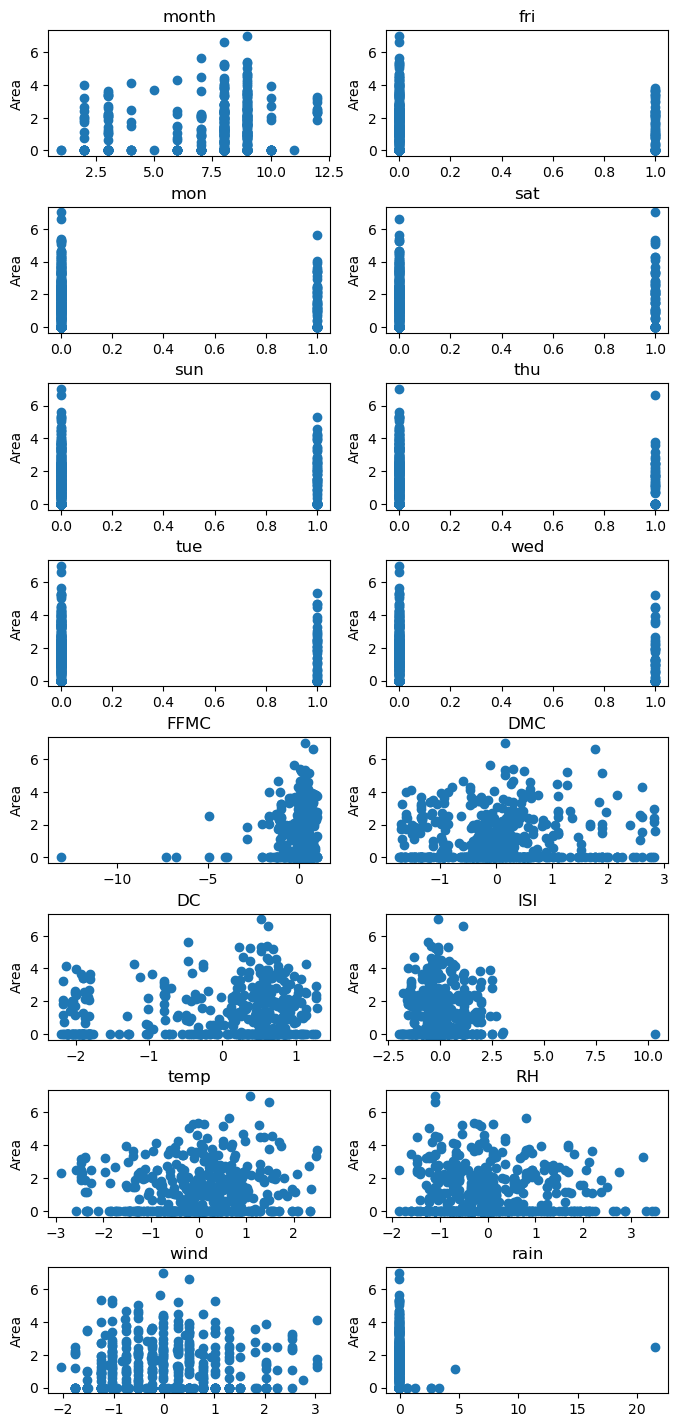

In [47]:
plt.figure(figsize=(8,20))
plot_count = 1

for col in features_df:
    plt.subplot(9,2,plot_count)
    plt.scatter(features_df[col], fires["log_area"])
    plt.title(col)
    plt.ylabel("Area")
    plot_count += 1
    plt.subplots_adjust(hspace = .4) 

It's a bit hard to tell what features have the best correlations to the area variable.  Month is defintley a factor.

### Forward sequential features selection

In [48]:
from sklearn.feature_selection import SequentialFeatureSelector

y = fires["log_area"]

sfs_model = LinearRegression()
sfs_model2 = LinearRegression()
sfs_model3 = LinearRegression()

forward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="forward")

forward4 = SequentialFeatureSelector(estimator=sfs_model2,
                                     n_features_to_select=4, 
                                     direction="forward")

forward6 = SequentialFeatureSelector(estimator=sfs_model3,
                                       n_features_to_select=6, 
                                       direction="forward")

forward2.fit(features_df, y)
forward4.fit(features_df, y)
forward6.fit(features_df, y)

print("Features selected in 2 feature model:", forward2.get_feature_names_out())
print("Features selected in 4 feature model:", forward4.get_feature_names_out())
print("Features selected in 6 feature model:", forward6.get_feature_names_out())

Features selected in 2 feature model: ['month' 'wind']
Features selected in 4 feature model: ['month' 'fri' 'FFMC' 'wind']
Features selected in 6 feature model: ['month' 'fri' 'sun' 'tue' 'FFMC' 'wind']


### Backward sequential features selection

In [49]:
backward2 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=2, 
                                     direction="backward")

backward4 = SequentialFeatureSelector(estimator=sfs_model,
                                     n_features_to_select=4, 
                                     direction="backward")

backward6 = SequentialFeatureSelector(estimator=sfs_model,
                                       n_features_to_select=6, 
                                       direction="backward")

backward2.fit(features_df, y)
backward4.fit(features_df, y)
backward6.fit(features_df, y)

print("Features selected in 2 feature model:", backward2.get_feature_names_out())
print("Features selected in 4 feature model:", backward4.get_feature_names_out())
print("Features selected in 6 feature model:", backward6.get_feature_names_out())

Features selected in 2 feature model: ['fri' 'tue']
Features selected in 4 feature model: ['fri' 'sat' 'sun' 'tue']
Features selected in 6 feature model: ['fri' 'mon' 'sat' 'sun' 'tue' 'wed']


### Creating models w/ sequential features

In [50]:
fw2_model = LinearRegression() # .fit(final[forward2.get_feature_names_out()], y)
fw4_model = LinearRegression() # .fit(final[forward4.get_feature_names_out()], y)
fw6_model = LinearRegression() # .fit(final[forward6.get_feature_names_out()], y)

bw2_model = LinearRegression() # .fit(final[backward2.get_feature_names_out()], y)
bw4_model = LinearRegression() # .fit(final[backward4.get_feature_names_out()], y)
bw6_model = LinearRegression() # .fit(final[backward6.get_feature_names_out()], y)

### Ridge and Lasso models

In [57]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(alphas = np.linspace(1, 10000, num=1000))
lasso = LassoCV(alphas = np.linspace(1, 10000, num=1000))

ridge.fit(features_df, y)
lasso.fit(features_df, y)

print("Ridge tuning parameter: ", ridge.alpha_)
print("LASSO tuning parameter: ", lasso.alpha_)

print("Ridge coefficients: ", ridge.coef_)
print("LASSO coefficients: ", lasso.coef_)

Ridge tuning parameter:  1812.6306306306308
LASSO tuning parameter:  10000.0
Ridge coefficients:  [ 0.03975263 -0.0061322  -0.00054743  0.0057012   0.00087149 -0.00318782
  0.0034999  -0.00020513  0.00750575  0.00991144  0.00147871 -0.00988468
  0.00630894 -0.0112039   0.02182828  0.00666208]
LASSO coefficients:  [ 0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0. -0.  0. -0.  0.  0.]


In [52]:
ridge = RidgeCV(alphas = np.linspace(1000, 1500, num=1000))
ridge.fit(features_df, y)
print("Ridge tuning parameter: ", ridge.alpha_)

Ridge tuning parameter:  1500.0


### Cross validating all models

In [55]:
from sklearn.model_selection import cross_val_score 
reference = LinearRegression()

reference_cv = cross_val_score(reference, features_df[["wind", "temp"]], y, cv = 5, scoring = "neg_mean_squared_error")
fw2_cv = cross_val_score(fw2_model, features_df[forward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw4_cv = cross_val_score(fw4_model, features_df[forward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
fw6_cv = cross_val_score(fw6_model, features_df[forward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw2_cv = cross_val_score(bw2_model, features_df[backward2.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw4_cv = cross_val_score(bw4_model, features_df[backward4.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
bw6_cv = cross_val_score(bw6_model, features_df[backward6.get_feature_names_out()], y, cv = 5, scoring = "neg_mean_squared_error")
ridge_cv = cross_val_score(ridge, features_df, y, cv = 5, scoring = "neg_mean_squared_error")

### Reviewing the MSE and STD dev for all models

In [56]:
print("Reference Model, Avg Test MSE: ", np.mean(reference_cv), " SD: ", np.std(reference_cv))
print("Forward-2 Model, Avg Test MSE: ", np.mean(fw2_cv), " SD: ", np.std(fw2_cv))
print("Forward-4 Model, Avg Test MSE: ", np.mean(fw4_cv), " SD: ", np.std(fw4_cv))
print("Forward-6 Model, Avg Test MSE: ", np.mean(fw6_cv), " SD: ", np.std(fw6_cv))
print("Backward-2 Model, Avg Test MSE: ", np.mean(bw2_cv), " SD: ", np.std(bw2_cv))
print("Backward-4 Model, Avg Test MSE: ", np.mean(bw4_cv), " SD: ", np.std(bw4_cv))
print("Backward-6 Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))
print("Ridge Model, Avg Test MSE: ", np.mean(bw6_cv), " SD: ", np.std(bw6_cv))

Reference Model, Avg Test MSE:  -2.204650013004116  SD:  1.060040355378637
Forward-2 Model, Avg Test MSE:  -2.1662868008699983  SD:  0.9777349381433581
Forward-4 Model, Avg Test MSE:  -2.1647458245182056  SD:  0.9770686745442914
Forward-6 Model, Avg Test MSE:  -2.1766658748712944  SD:  0.9804129153161028
Backward-2 Model, Avg Test MSE:  -2.176620001011036  SD:  1.009024419345114
Backward-4 Model, Avg Test MSE:  -2.1870218207891896  SD:  1.0102225286252613
Backward-6 Model, Avg Test MSE:  -2.206258512893414  SD:  1.0206926341595277
Ridge Model, Avg Test MSE:  -2.206258512893414  SD:  1.0206926341595277


All the models MSE are fairly close with the foward 2 feature model being the best with the lowest standard deviation. With a SD close to 1 and MSE of -2, these are not great precitors of our target variable. Note we used a log transformation to the area target varible to increase normalization (which is better for linear models).  Therefore, the actual MSEs will be a bit higher. To get actual area predictions we would need to run the log predictions and transform this back with np.exp (the inverse of a log function)